# Downloading Data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("htagholdings/property-sales")

print("Path to dataset files:", path)

100%|██████████| 162k/162k [00:00<00:00, 51.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/htagholdings/property-sales/versions/3


In [4]:
import os
import pandas as pd

os.listdir(path)

['ma_lga_12345.csv', 'raw_sales.csv']

In [5]:
df_ma = pd.read_csv(path + "/ma_lga_12345.csv")
df_raw = pd.read_csv(path + "/raw_sales.csv")

In [6]:
df_ma.head()

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2


In [7]:
df_raw.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [9]:
df_raw.info()
df_ma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   saledate  347 non-null    object
 1   MA        347 non-null    int64 
 2   type      347 non-null    object
 3   bedrooms  347 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.0+ KB


# Step 1: Importing Libraries


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Step 2: Preprocessing the Data

In [10]:
# Converting dates to datetime
df_ma['saledate'] = pd.to_datetime(df_ma['saledate'], dayfirst=True)
df_raw['datesold'] = pd.to_datetime(df_raw['datesold'])

# Sorting values by date
df_ma = df_ma.sort_values("saledate")
df_raw = df_raw.sort_values("datesold")

# Grouping df_raw monthly
df_monthly = df_raw.resample("M", on="datesold").mean(numeric_only=True)
df_monthly = df_monthly[['price']].dropna()

<ipython-input-10-69c22cba3a9e>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_raw.resample("M", on="datesold").mean(numeric_only=True)


# Step 3: Plotting Sales Trends



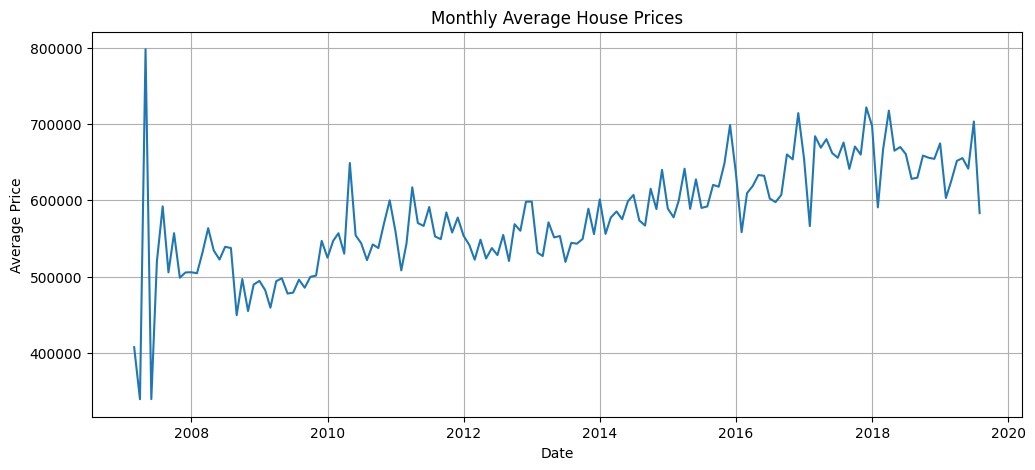

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(df_monthly.index, df_monthly['price'])
plt.title('Monthly Average House Prices')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.grid()
plt.show()

# Step 4: ARMA/ARIMA Model


I'll try ARIMA (ARMA is ARIMA without integration d=0).

<ipython-input-12-5fe590f65d5d>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(df_monthly.index[-1], periods=12, freq='M'), forecast, label='Forecast')


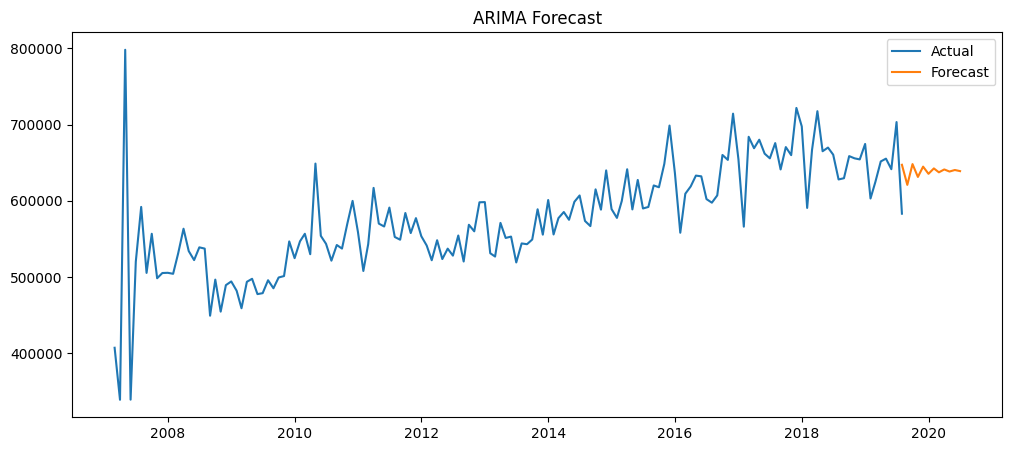

In [12]:
# Fitting ARIMA (ARMA with d=0 is possible too)
model_arima = ARIMA(df_monthly['price'], order=(2, 1, 2))
model_fit = model_arima.fit()

# Forecasting next 12 months
forecast = model_fit.forecast(steps=12)

# Plotting forecast
plt.figure(figsize=(12,5))
plt.plot(df_monthly.index, df_monthly['price'], label='Actual')
plt.plot(pd.date_range(df_monthly.index[-1], periods=12, freq='M'), forecast, label='Forecast')
plt.legend()
plt.title("ARIMA Forecast")
plt.show()


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluation metrics
mae_arima = mean_absolute_error(y_true_arima, y_pred_arima)
rmse_arima = np.sqrt(mean_squared_error(y_true_arima, y_pred_arima))  # Manual RMSE
r2_arima = r2_score(y_true_arima, y_pred_arima)

print(f"ARIMA Model Evaluation:")
print(f"MAE: {mae_arima:.2f}")
print(f"RMSE: {rmse_arima:.2f}")
print(f"R² Score: {r2_arima:.2f}")

ARIMA Model Evaluation:
MAE: 26307.39
RMSE: 31664.90
R² Score: -0.09


# Step 5: Preparing for RNN (LSTM)


In [13]:
# Normalizing prices
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df_monthly[['price']])

# Creating sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_prices)

# Splitting into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Step 6: Building and Trainning LSTM Model


In [14]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Trainning
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=16)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.2205 - val_loss: 0.3216
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1493 - val_loss: 0.1961
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0822 - val_loss: 0.0745
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0207 - val_loss: 0.0074
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0145 - val_loss: 0.0058
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0070 - val_loss: 0.0143
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0080 - val_loss: 0.0118
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 13/20


# Step 7: Making Predictions and Plotting


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


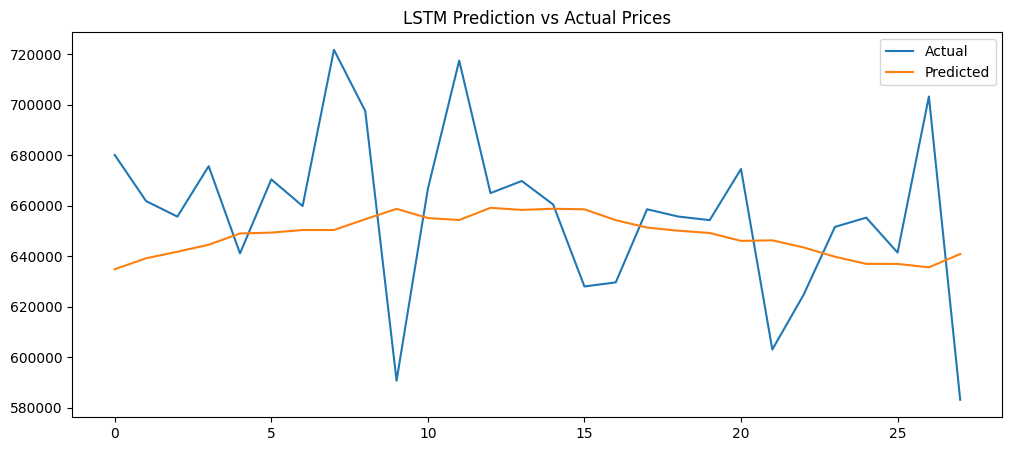

In [15]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(y_test_true, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title('LSTM Prediction vs Actual Prices')
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# MAE
mae_lstm = mean_absolute_error(y_test_true, predicted)

# RMSE (manual calculation)
rmse_lstm = np.sqrt(mean_squared_error(y_test_true, predicted))

# R² score
r2_lstm = r2_score(y_test_true, predicted)

print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R² Score: {r2_lstm:.2f}")

MAE: 26817.98
RMSE: 34460.66
R² Score: -0.14


# Summary:
Both models exhibit negative R² scores, meaning that neither model is able to explain the variability in the data effectively. The ARIMA model performs slightly better in terms of MAE and RMSE. However, both models are relatively ineffective at capturing the underlying patterns in the data, as indicated by their low performance metrics. This suggests that other model architectures or feature engineering might be needed to improve predictive accuracy.